In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print("x_train.shape = {}".format(x_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("x_test.shape = {}".format(x_test.shape))
print("y_test.shape = {}".format(y_test.shape))

x_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
x_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)


### Get just cars.

In [4]:
def get_cifar_cars(features, labels, class_idx):
    """Returns features of only chosen class and features of other classes.

    Args:
        features: np.array, array of features.
        labels: np.array, array of int labels.
        class_idx: int, index of chosen class.
    Returns:
        Numpy arrays of chosen class features and other class features.
    """
    in_class = features[labels.flatten() == class_idx, :, :, :]
    out_class = features[labels.flatten() != class_idx, :, :, :]

    sample_indices = np.random.choice(
        a=np.arange(out_class.shape[0]), size=in_class.shape[0], replace=False
    )
    out_class = out_class[sample_indices, :, :, :]

    return in_class, out_class


In [5]:
car_train, anom_train = get_cifar_cars(
    features=x_train, labels=y_train, class_idx=1
)
car_test, anom_test = get_cifar_cars(
    features=x_test, labels=y_test, class_idx=1
)

In [6]:
print("car_train.shape = {}".format(car_train.shape))
print("anom_train.shape = {}".format(anom_train.shape))
print("car_test.shape = {}".format(car_test.shape))
print("anom_test.shape = {}".format(anom_test.shape))

car_train.shape = (5000, 32, 32, 3)
anom_train.shape = (5000, 32, 32, 3)
car_test.shape = (1000, 32, 32, 3)
anom_test.shape = (1000, 32, 32, 3)


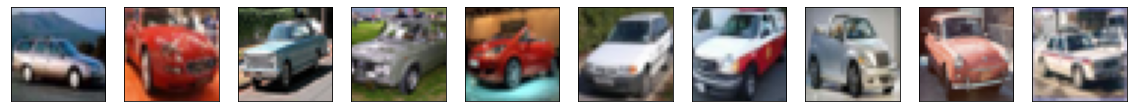

In [7]:
num_images = min(len(car_train), 10)

plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(car_train[i], cmap=plt.cm.binary)
plt.show()

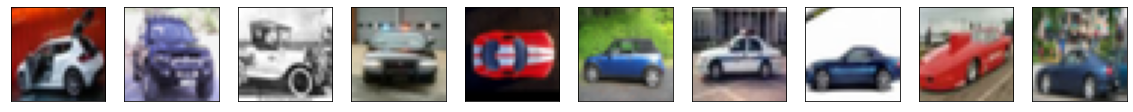

In [8]:
num_images = min(len(car_test), 10)

plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(car_test[i], cmap=plt.cm.binary)
plt.show()

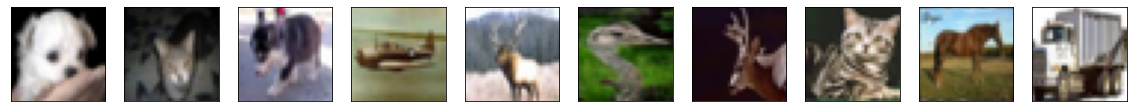

In [9]:
num_images = min(len(anom_train), 10)

plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(anom_train[i], cmap=plt.cm.binary)
plt.show()

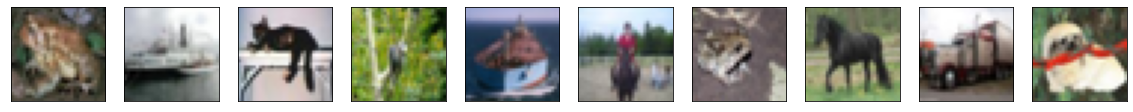

In [10]:
num_images = min(len(anom_test), 10)

plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(anom_test[i], cmap=plt.cm.binary)
plt.show()

## Write

In [37]:
def write_tf_record(filepath, data):
    """Writes TFRecord files of given data to given filepath.

    Args:
        filepath: str, filepath location.
        data: dict, np.arrays of feature and label data.
    """
    with tf.io.TFRecordWriter(path=filepath) as ofp:
        for i in range(len(data["image_raw"])):
            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        "image_raw": tf.train.Feature(
                            bytes_list=tf.train.BytesList(
                                value=[data["image_raw"][i].tobytes()]
                            )
                        ),
                        "label": tf.train.Feature(
                            int64_list=tf.train.Int64List(
                                value=[data["label"][i]]
                            )
                        )
                    }
                )
            )
            ofp.write(example.SerializeToString())


In [75]:
def create_tf_record_shards(num_shards, filepath, data):
    """Creates TFRecord shards of given data at given filepath.

    Args:
        num_shards: int, number of file shards to split data into.
        filepath: str, filepath location.
        data: dict, np.arrays of feature and label data.
    """
    dataset_len = data[list(data.keys())[0]].shape[0]
    num_shards = min(num_shards, dataset_len)
    shard_size = dataset_len // num_shards
    remainder = dataset_len % num_shards
    loop_limit = num_shards if remainder == 0 else num_shards - 1
    for i in range(loop_limit):
        write_tf_record(
            filepath="{}_{}.tfrecord".format(filepath, i),
            data={
                key: value[shard_size * i:shard_size * (i + 1)]
                for key, value in data.items()
            }
        )

    if remainder > 0:
        write_tf_record(
            filepath="{}_{}.tfrecord".format(filepath, num_shards - 1),
            data={
                key: value[shard_size * (num_shards - 1):shard_size * num_shards + remainder]
                for key, value in data.items()
            }
        )


In [76]:
# Set number of shards to split dataset into.
num_shards = 10

# Loop through each progressive resolution image size.
for i in range(4):
    img_sz = 4 * 2 ** i
    print("\nWriting {0}_{0} TF Records!".format(img_sz))

    # Cars
    create_tf_record_shards(
        num_shards=num_shards,
        filepath="data/cifar10_car/train_{0}x{0}".format(img_sz),
        data={
            "image_raw": tf.image.resize(
                images=car_train, size=(img_sz, img_sz), method="nearest"
            ).numpy(),
            "label": np.ones(shape=[car_train.shape[0]], dtype=np.int32)
        }
    )
    create_tf_record_shards(
        num_shards=num_shards,
        filepath="data/cifar10_car/test_{0}x{0}".format(img_sz),
        data={
            "image_raw": tf.image.resize(
                images=car_test, size=(img_sz, img_sz), method="nearest"
            ).numpy(),
            "label": np.ones(shape=[car_test.shape[0]], dtype=np.int32)
        }
    )

    # Non-cars
    create_tf_record_shards(
        num_shards=num_shards,
        filepath="data/cifar10_non_car/train_{0}x{0}".format(img_sz),
        data={
            "image_raw": tf.image.resize(
                images=anom_train, size=(img_sz, img_sz), method="nearest"
            ).numpy(),
            "label": np.ones(shape=[car_train.shape[0]], dtype=np.int32)
        }
    )
    create_tf_record_shards(
        num_shards=num_shards,
        filepath="data/cifar10_non_car/test_{0}x{0}".format(img_sz),
        data={
            "image_raw": tf.image.resize(
                images=anom_test, size=(img_sz, img_sz), method="nearest"
            ).numpy(),
            "label": np.ones(shape=[car_test.shape[0]], dtype=np.int32)
        }
    )


Writing 4_4 TF Records!

Writing 8_8 TF Records!

Writing 16_16 TF Records!

Writing 32_32 TF Records!


## Read

In [65]:
def print_obj(function_name, object_name, object_value):
    """Prints enclosing function, object name, and object value.

    Args:
        function_name: str, name of function.
        object_name: str, name of object.
        object_value: object, value of passed object.
    """
#     pass
    print("{}: {} = {}".format(function_name, object_name, object_value))

In [66]:
def decode_example(protos, params):
    """Decodes TFRecord file into tensors.

    Given protobufs, decode into image and label tensors.

    Args:
        protos: protobufs from TFRecord file.
        params: dict, user passed parameters.

    Returns:
        Image and label tensors.
    """
    # Create feature schema map for protos.
    features = {
        "image_raw": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        "label": tf.io.FixedLenFeature(shape=[], dtype=tf.int64)
    }

    # Parse features from tf.Example.
    parsed_features = tf.io.parse_single_example(
        serialized=protos, features=features
    )
    print_obj("\ndecode_example", "features", features)

    # Convert from a scalar string tensor (whose single string has
    # length height * width * depth) to a uint8 tensor with shape
    # [height * width * depth].
    image = tf.io.decode_raw(
        input_bytes=parsed_features["image_raw"], out_type=tf.uint8
    )
    print_obj("decode_example", "image", image)

    # Reshape flattened image back into normal dimensions.
    image = tf.reshape(
        tensor=image,
        shape=[params["height"], params["width"], params["depth"]]
    )
    print_obj("decode_example", "image", image)

    # Convert from [0, 255] -> [-1.0, 1.0] floats.
    image_scaled = tf.cast(x=image, dtype=tf.float32) * (2. / 255) - 1.0
    print_obj("decode_example", "image", image)

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(x=parsed_features["label"], dtype=tf.int32)
    print_obj("decode_example", "label", label)

    return {"image": image, "image_scaled": image_scaled}, label


def read_dataset(filename, mode, batch_size, params):
    """Reads CSV time series data using tf.data, doing necessary preprocessing.

    Given filename, mode, batch size, and other parameters, read CSV dataset
    using Dataset API, apply necessary preprocessing, and return an input
    function to the Estimator API.

    Args:
        filename: str, file pattern that to read into our tf.data dataset.
        mode: The estimator ModeKeys. Can be TRAIN or EVAL.
        batch_size: int, number of examples per batch.
        params: dict, dictionary of user passed parameters.

    Returns:
        An input function.
    """
    def _input_fn():
        """Wrapper input function used by Estimator API to get data tensors.

        Returns:
            Batched dataset object of dictionary of feature tensors and label
                tensor.
        """
        # Create list of files that match pattern.
        file_list = tf.io.gfile.glob(pattern=filename)

        # Create dataset from file list.
        dataset = tf.data.TFRecordDataset(
            filenames=file_list, num_parallel_reads=40
        )

        # Shuffle and repeat if training with fused op.
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.apply(
                tf.contrib.data.shuffle_and_repeat(
                    buffer_size=50 * batch_size,
                    count=None  # indefinitely
                )
            )

        # Decode example into a features dictionary of tensors, then batch.
        dataset = dataset.map(
            map_func=lambda x: decode_example(
                protos=x,
                params=params
            ),
            num_parallel_calls=4
        )

        dataset = dataset.batch(batch_size=batch_size)

        # Prefetch data to improve latency.
        dataset = dataset.prefetch(buffer_size=2)

        return dataset
    return _input_fn


In [67]:
def try_out_input_function(arguments, print_out=False):
    """Trys out input function for testing purposes.

    Args:
        arguments: dict, user passed parameters.
    """
    fn = read_dataset(
        filename=arguments["filename"],
        mode=tf.estimator.ModeKeys.EVAL,
        batch_size=8,
        params=arguments
    )

    dataset = fn()

    batches = [batch for batch in dataset]
    features, labels = batches[0]
    print("features[image].shape = {}".format(features["image"].shape))
    print("labels.shape = {}".format(labels.shape))
#         print("features = \n{}".format(features))
    print("labels = \n{}".format(labels))

    return features, labels


In [68]:
def plot_images(images):
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
    plt.show()


Image size = 4x4

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 4, 4, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


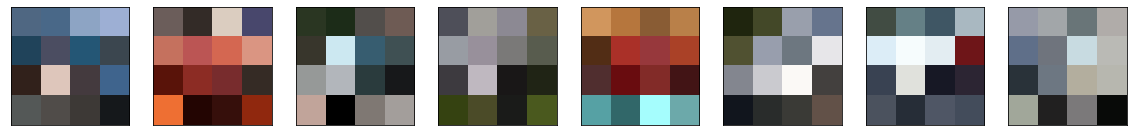


Image size = 8x8

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 8, 8, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


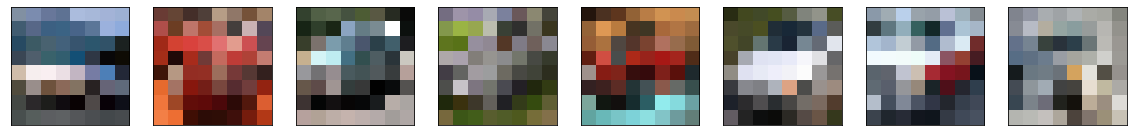


Image size = 16x16

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 16, 16, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


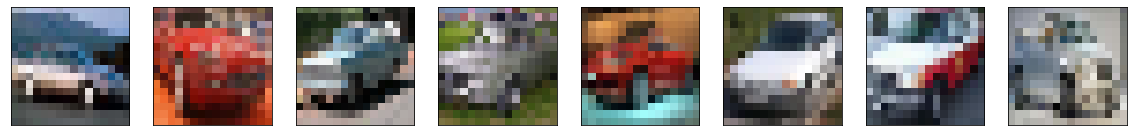


Image size = 32x32

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 32, 32, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


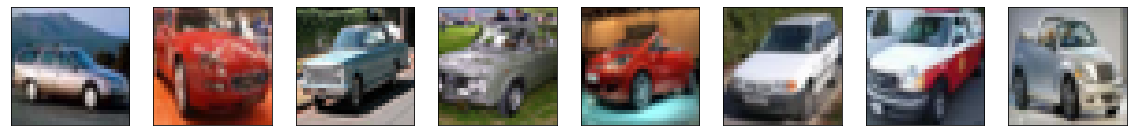

In [70]:
# Loop through each progressive resolution image size.
for i in range(4):
    img_sz = 4 * 2 ** i
    print("\nImage size = {0}x{0}".format(img_sz))

    features, labels = try_out_input_function(
        arguments={
            "filename": "data/cifar10_car/train_{0}x{0}_0.tfrecord".format(
                img_sz
            ),
            "height": img_sz,
            "width": img_sz,
            "depth": 3
        },
        print_out=True
    )
    plot_images(features["image"])


Image size = 4x4

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 4, 4, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


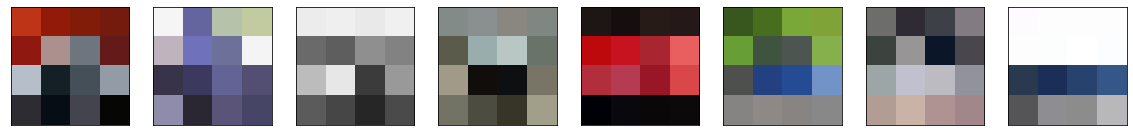


Image size = 8x8

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 8, 8, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


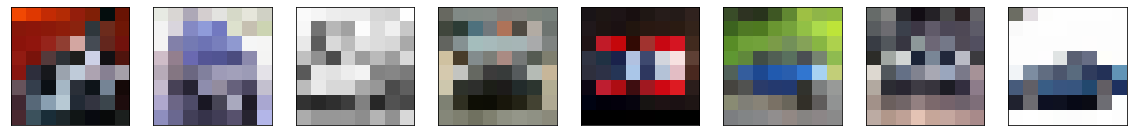


Image size = 16x16

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 16, 16, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


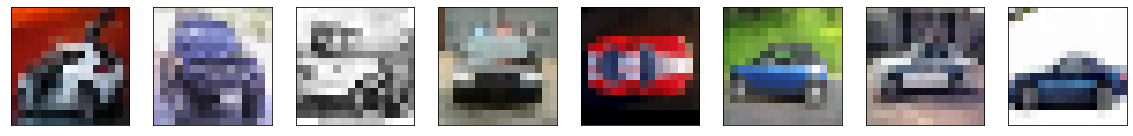


Image size = 32x32

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 32, 32, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


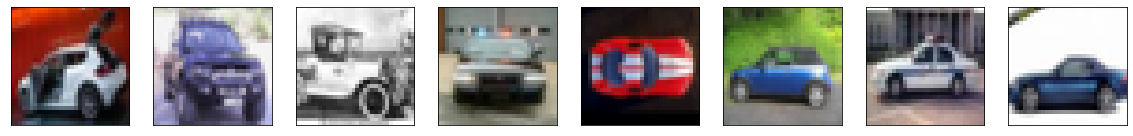

In [71]:
# Loop through each progressive resolution image size.
for i in range(4):
    img_sz = 4 * 2 ** i
    print("\nImage size = {0}x{0}".format(img_sz))

    features, labels = try_out_input_function(
        arguments={
            "filename": "data/cifar10_car/test_{0}x{0}_0.tfrecord".format(
                img_sz
            ),
            "height": img_sz,
            "width": img_sz,
            "depth": 3
        },
        print_out=True
    )
    plot_images(features["image"])


Image size = 4x4

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 4, 4, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


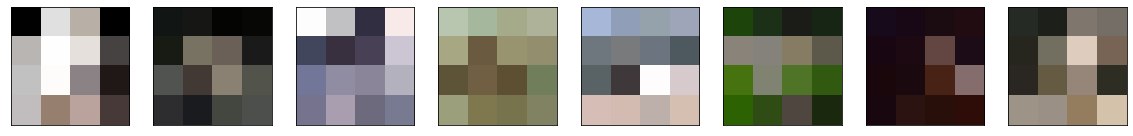


Image size = 8x8

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 8, 8, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


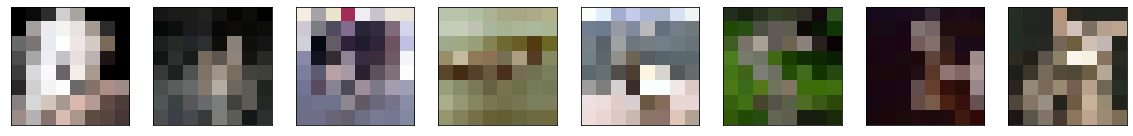


Image size = 16x16

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 16, 16, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


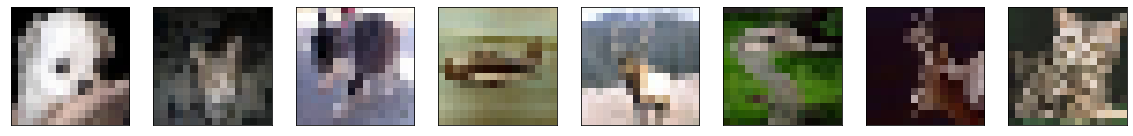


Image size = 32x32

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 32, 32, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


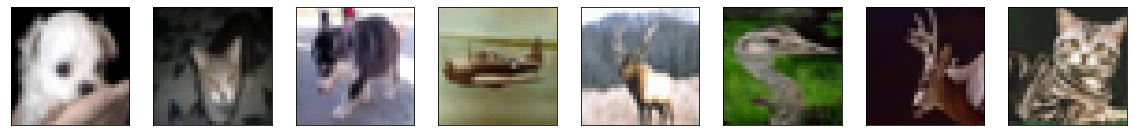

In [72]:
# Loop through each progressive resolution image size.
for i in range(4):
    img_sz = 4 * 2 ** i
    print("\nImage size = {0}x{0}".format(img_sz))

    features, labels = try_out_input_function(
        arguments={
            "filename": "data/cifar10_non_car/train_{0}x{0}_0.tfrecord".format(
                img_sz
            ),
            "height": img_sz,
            "width": img_sz,
            "depth": 3
        },
        print_out=True
    )
    plot_images(features["image"])


Image size = 4x4

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(4, 4, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 4, 4, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


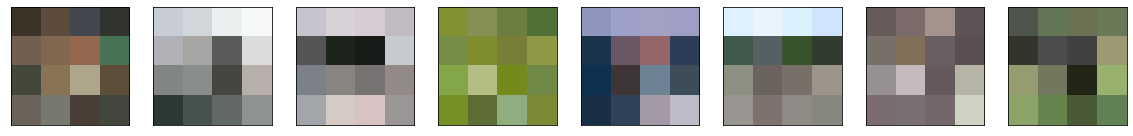


Image size = 8x8

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(8, 8, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 8, 8, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


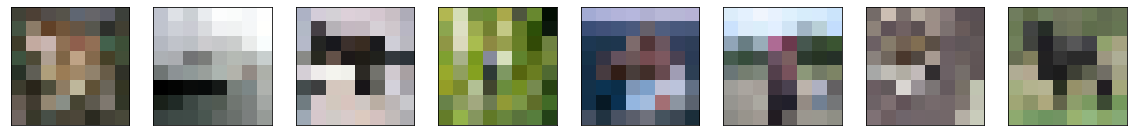


Image size = 16x16

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(16, 16, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 16, 16, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


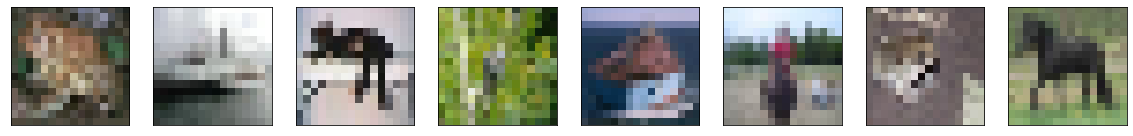


Image size = 32x32

decode_example: features = {'image_raw': FixedLenFeature(shape=[], dtype=tf.string, default_value=None), 'label': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
decode_example: image = Tensor("DecodeRaw:0", shape=(None,), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: image = Tensor("Reshape:0", shape=(32, 32, 3), dtype=uint8)
decode_example: label = Tensor("Cast_1:0", shape=(), dtype=int32)
features[image].shape = (8, 32, 32, 3)
labels.shape = (8,)
labels = 
[1 1 1 1 1 1 1 1]


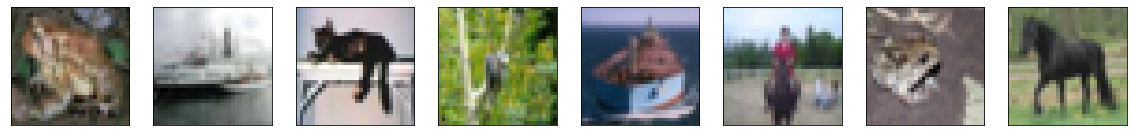

In [73]:
# Loop through each progressive resolution image size.
for i in range(4):
    img_sz = 4 * 2 ** i
    print("\nImage size = {0}x{0}".format(img_sz))

    features, labels = try_out_input_function(
        arguments={
            "filename": "data/cifar10_non_car/test_{0}x{0}_0.tfrecord".format(
                img_sz
            ),
            "height": img_sz,
            "width": img_sz,
            "depth": 3
        },
        print_out=True
    )
    plot_images(features["image"])